## 1 . About Dataset
Context
This dataset is often used for varying projects with anime faces. I will keep this dataset up-to-date and clean, along with including fun scripts for generating anime waifus!

Content
This dataset has 63,632 "high-quality" anime faces… but let's be real… all anime girls are high-quality.

Acknowledgements
Based on:
Mckinsey666's dataset

Inspiration
I just want to generate perfect waifus. It's a simple dream. I will expand and alter this dataset to move towards a pure dataset of cute female anime faces.

Example Output
In the Starter: Anime Face Dataset kernel, you will find the code to create this:

<img src = 'https://raw.githubusercontent.com/Mckinsey666/Anime-Face-Dataset/master/test.jpg'>

In [1]:
!pip install opendatasets --q
import numpy as np 
import pandas as pd  
from PIL import Image  
import matplotlib  
import matplotlib.pyplot as plt  
import torch  
from torch import nn 
from torch import optim  
import torch.optim as optim  
import torch.nn.functional as F 
from torchvision import transforms, models 
from tqdm.notebook import tqdm
from torch.autograd import Variable  
from torchvision.datasets import ImageFolder 
import torch.utils.data as data 
from torch.utils.data import DataLoader, TensorDataset  
import opendatasets as od
import os

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

15dc5957cd20c138b5d230e928d9a6ac

In [3]:
dataset_url = "https://www.kaggle.com/splcher/animefacedataset"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  skjha69


Your Kaggle Key:

  ································


Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:06<00:00, 68.3MB/s] 


In [4]:
import os
data_dir = '/kaggle/working/animefacedataset'
os.listdir(data_dir)

['images']

In [5]:
dataset_dir = '/kaggle/working/animefacedataset/'

## 2 . Data Augmentation/Cleaning and Image Folder
We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">


3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

In [6]:
from torchvision.transforms import v2
IMAGE_SIZE = 64
IMG_CHANNELS = 3

data_transforms = {
    'train': transforms.Compose([
        v2.Resize(size = (IMAGE_SIZE,IMAGE_SIZE)),
        v2.ToTensor(),
        v2.CenterCrop(IMAGE_SIZE)
    
    ]), }

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [7]:
train_data = ImageFolder(root=dataset_dir,
                            transform=data_transforms['train'],
                            target_transform=None,
                            is_valid_file=None)

### 2.1 Visualizing  data

In [8]:
class_names = train_data.classes
image , label = train_data[9]
image.shape , label

(torch.Size([3, 64, 64]), 0)

Text(0.5, 1.0, 'images : 0')

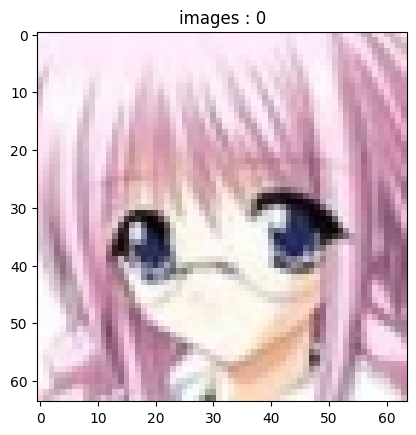

In [9]:
plt.imshow(image.permute(1, 2, 0))
plt.title(f'{class_names[label]} : {label}')

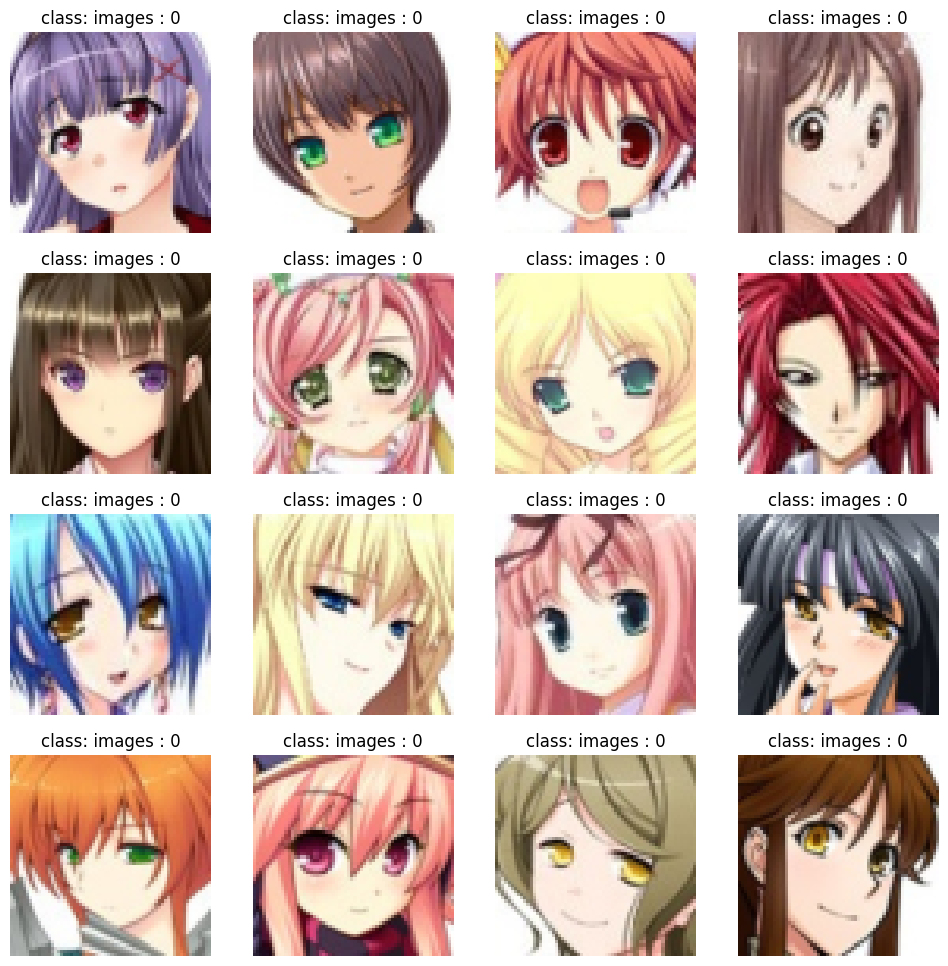

In [10]:
import random
import torch
import matplotlib.pyplot as plt

def plot_random_images(dataset:torch.utils.data.dataset.Dataset ,
                          class_names : list[str] = None,
                          n : int = 3,
                          seed : int = None)->None:
    if seed:
        random.seed(seed)

    fig = plt.figure(figsize=(12, 12))
    for i in range(1,n*n+1):
        random_idx = torch.randint(0 , len(dataset), size = [1]).item()
        image, target = dataset[random_idx]
        fig.add_subplot(n,n,i)
        plt.imshow(image.permute(1,2,0))
        plt.axis(False);
        if class_names:
            title = f"class: {class_names[target]} : {target}"
        else:
            title = None
        plt.title(title)
        
plot_random_images(dataset = train_data, n = 4 , class_names = class_names )

### 2.2 Creating Dataloaders

In [11]:
from torch.utils.data import DataLoader
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32 

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = True,
)

## 3. Device Data Loader for PyTorch

This code snippet offers utilities for seamless data movement between CPU and GPU devices using PyTorch. `get_default_device()` selects a GPU if available, falling back to CPU otherwise. `to_device(data, device)` efficiently moves tensors to the specified device, handling both individual tensors and collections. The `DeviceDataLoader` class wraps a PyTorch DataLoader, ensuring data batches are transferred to the designated device upon iteration. This setup enhances performance and flexibility when working with large datasets and varying hardware configurations. Usage involves initializing a DataLoader, obtaining the target device, and wrapping the DataLoader with `DeviceDataLoader` for seamless device handling during data processing. This concise utility simplifies the management of device resources in PyTorch workflows.

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dataloader = DeviceDataLoader(train_dataloader, device)

## 4. Generator and Discriminator | DCGAN

### Generator Model Architecture:
The generator in DCGANs typically consists of multiple layers of transposed convolutional (deconvolutional) layers, followed by batch normalization and ReLU activation functions. It takes random noise as input and gradually upsamples it to generate realistic images. The final layer usually applies a Tanh activation function to squash the pixel values to the range [-1, 1], suitable for image data.

### Discriminator Model Architecture:
The discriminator is a convolutional neural network (CNN) that acts as a binary classifier. It takes an image as input and outputs a probability indicating whether the input image is real (from the dataset) or fake (generated by the generator). The discriminator typically consists of convolutional layers followed by batch normalization and LeakyReLU activation functions. The output layer uses a sigmoid activation function to produce the probability score.

### Training Process:
1. **Initialization**: Initialize the generator and discriminator networks with random weights.
  
2. **Data Preparation**: Prepare a dataset of real images. For each training iteration, sample a batch of real images from the dataset and generate a batch of fake images using the generator.
  
3. **Training Discriminator**: Train the discriminator to distinguish between real and fake images. Compute the loss (commonly binary cross-entropy loss) between the discriminator's predictions and the ground truth labels (real or fake). Backpropagate the gradients and update the discriminator's weights to minimize the loss.

4. **Training Generator**: Train the generator to generate more realistic images. Generate a new batch of fake images using the current generator. Compute the loss based on how well the discriminator was fooled by these fake images. Backpropagate the gradients through the generator and update its weights to maximize this loss, essentially encouraging it to generate more convincing images.

5. **Iterate**: Repeat steps 3 and 4 for a fixed number of iterations or until convergence.

### Additional Considerations:
- **Hyperparameters**: DCGANs require careful tuning of hyperparameters such as learning rates, batch sizes, and architectural details to achieve stable training.
  
- **Normalization**: Batch normalization is often used in both the generator and discriminator to stabilize training and improve convergence.
  
- **Loss Functions**: The choice of loss functions can vary, but commonly used ones include binary cross-entropy loss for the discriminator and various measures of similarity (e.g., mean squared error) between the generated and real images for the generator.

DCGANs have been influential in the field of generative modeling, paving the way for more sophisticated models like StyleGAN and BigGAN.

<img src = 'https://miro.medium.com/v2/resize:fit:1400/format:webp/1*rdXKdyfNjorzP10ZA3yNmQ.png'>

In [15]:
import torch.nn as nn

# input -> batch_size x 3 x 64 x 64 , output -> batch_size x 1 x 1 x 1
class Discriminator(nn.Module):
    def __init__(self , in_channels):
        super(Discriminator,self).__init__()

        self.Network = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            self._create_block(in_channels=64 , out_channels=128 , kernel_size=4,stride=2, padding=1),
            self._create_block(in_channels=128 , out_channels=256 , kernel_size=4,stride=2, padding=1),
            self._create_block(in_channels=256 , out_channels=512 , kernel_size=4,stride=2, padding=1),
    
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=2, padding=0),
            nn.Flatten(),
            nn.Sigmoid(),
        
        )

    def _create_block(self,in_channels, out_channels , kernel_size , padding ,stride):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size,padding=padding, stride=stride , bias= False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self,x):
        return self.Network(x)
    
# input -> batch_size x fixed_noise x 1 x 1 , output -> batch_size x 3 x 64 x 64
class Generator(nn.Module):
    def __init__(self , noise_channels , img_channels):
        super(Generator , self).__init__()

        self.Network = nn.Sequential(

            self._create_block(in_channels=noise_channels, out_channels=512, kernel_size=4, padding=0 , stride=1),
            self._create_block(in_channels=512, out_channels=256, kernel_size=4, padding=1 , stride=2),   
            self._create_block(in_channels=256, out_channels=128, kernel_size=4, padding=1 , stride=2),   
            self._create_block(in_channels=128, out_channels=64, kernel_size=4, padding=1 , stride=2), 

            nn.ConvTranspose2d(in_channels=64, out_channels=img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )


    def _create_block(self,in_channels, out_channels , kernel_size , padding ,stride):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride, padding=padding,bias= False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.Network(x)

In [16]:
NOISE_DIM = 128
IMG_CHANNELS = 3
generator = Generator(noise_channels = NOISE_DIM , img_channels = IMG_CHANNELS).to(device)
discriminator = Discriminator(in_channels = IMG_CHANNELS).to(device)
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

## 5. Display Batch of Images from DataLoader

This code snippet provides functions to visualize a batch of images from a PyTorch DataLoader in a Jupyter notebook. Below is a concise explanation of the key components:

### 1. `make_image_grid(images, nmax=None)` Function:
- Displays a grid of images.
- **Parameters:**
  - `images (torch.Tensor)`: A batch of images.
  - `nmax (int, optional)`: Maximum number of images to display. If None, display all images. Defaults to None.

### 2. `show_batch(dataloader, make_image_grid, nmax=64)` Function:
- Fetches a batch of images from a DataLoader and displays them using the `make_image_grid` function.
- **Parameters:**
  - `dataloader (torch.utils.data.DataLoader)`: The DataLoader to fetch the batch of images from.
  - `make_image_grid (callable)`: The function used to create and display the image grid.
  - `nmax (int, optional)`: Maximum number of images to display. Defaults to 64.


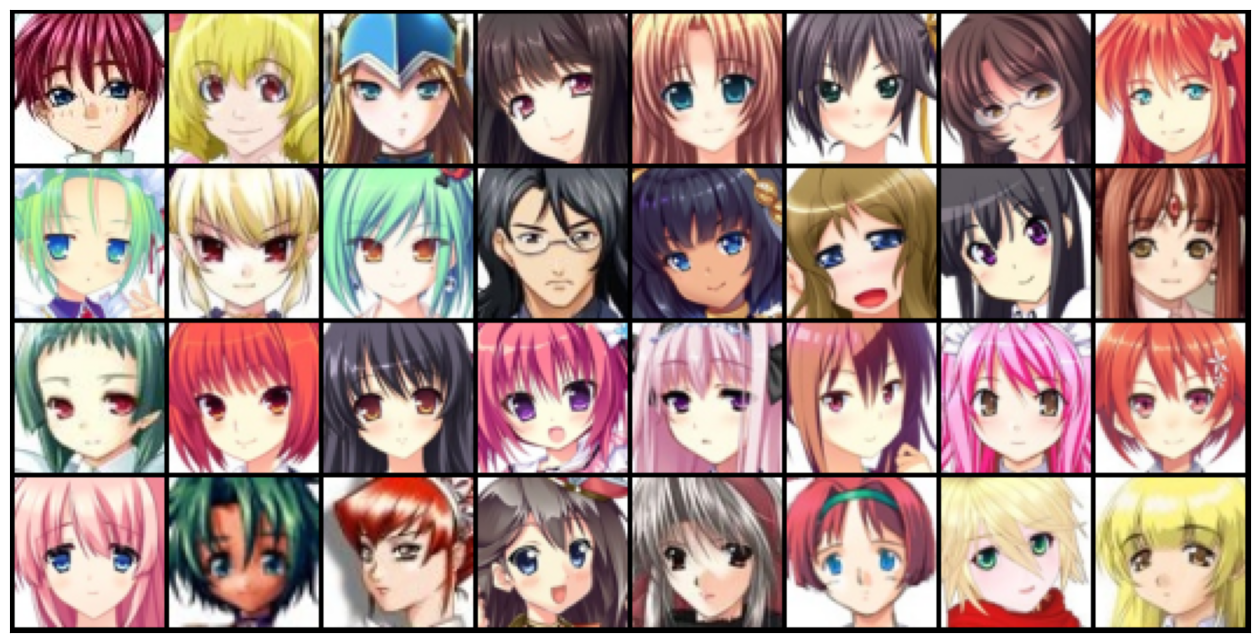

In [17]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def make_image_grid(images:torch.Tensor, 
                    nmax=None) -> None:
    """
    Display a grid of images.

    Parameters:
    images (torch.Tensor): A batch of images of shape (batch_size, 3, 256, 256).
    nmax (int, optional): Maximum number of images to display. If None, display all images in the batch. Defaults to None.

    Returns:
    None: This function does not return any value. It displays a grid of images.
    """
    if nmax is not None:
        images = images[:nmax]
    
    # Create the grid of images
    grid_img = make_grid(images, nrow=8, padding=2, normalize=True)
    
    # Plot the grid
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.imshow(grid_img.permute(1, 2, 0))
    ax.set_xticks([]) 
    ax.set_yticks([])
    plt.show()


def show_batch(dataloader: torch.utils.data.DataLoader, 
               make_image_grid: callable, 
               nmax: int = 64) -> None:
    """
    Display a batch of images from a DataLoader using a specified function to create an image grid.

    Parameters:
    dataloader (torch.utils.data.DataLoader): The DataLoader to fetch the batch of images from.
    make_image_grid (callable): The function used to create and display the image grid.
    nmax (int, optional): The maximum number of images to display. Defaults to 64.

    Returns:
    None: This function does not return any value. It displays a batch of images using the provided image grid function.
    """
    for images, _ in dataloader:
        make_image_grid(images.cpu(), nmax)
        break
show_batch(train_dataloader , make_image_grid)

## 6. Generate and Save Image Grids using Generator Model

This code snippet offers a function to generate and save a grid of images using a generator model in PyTorch. Here's a brief explanation:

### `save_image_grid(index, generator, latent_tensors, show=True)` Function:
- Generates a grid of images using a generator model and saves it as a PNG file.
- **Parameters:**
  - `index (int)`: Index used to name the saved image file.
  - `generator (torch.nn.Module)`: Generator model to produce images from latent tensors.
  - `latent_tensors (torch.Tensor)`: Latent tensors used as input to the generator.
  - `show (bool, optional)`: Whether to display the generated image grid. Defaults to True.

In [18]:
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_image_grid(index : int,
                 generator:torch.nn.Module,
                 latent_tensors : torch.Tensor,
                 show=True) -> None:
    """
    Generate and save a grid of images using a generator model, and optionally display the grid.

    Parameters:
    index (int): The index used to name the saved image file.
    generator (torch.nn.Module): The generator model to produce images from latent tensors.
    latent_tensors (torch.Tensor) size = [batch_size,noise_dim,1,1]: The latent tensors used as input to the generator.
    show (bool, optional): Whether to display the generated image grid. Defaults to True.

    Returns:
    None: This function does not return any value. It saves and optionally displays a grid of generated images.
    """

    sample_dir = 'Generated Images'
    os.makedirs(sample_dir, exist_ok=True)
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(14, 14))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Saving generated-images-0000.png


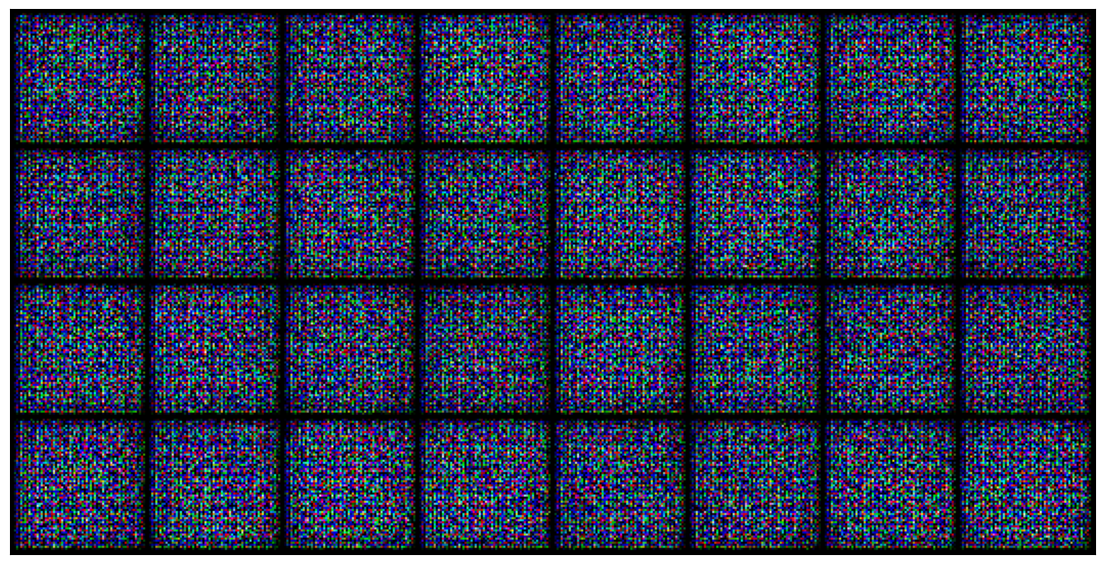

In [19]:
fixed_latent = torch.randn([BATCH_SIZE , NOISE_DIM , 1, 1] ,device = device)
save_image_grid(0, generator,fixed_latent)

## 7. Functionalizing Training functions

<p>This code segment provides functions to train a Generative Adversarial Network (GAN) consisting of a discriminator and a generator. Here's a brief overview:</p>

<h3><code>train_discriminator</code> Function:</h3>
<ul>
  <li>Trains the discriminator model on both real and generated (fake) images.</li>
  <li>Updates the discriminator's parameters to minimize the loss.</li>
  <li>Calculates the total loss, average score for real images, and average score for fake images.</li>
</ul>

<h3><code>train_generator</code> Function:</h3>
<ul>
  <li>Trains the generator model to produce images that can fool the discriminator.</li>
  <li>Updates the generator's parameters to minimize the loss.</li>
  <li>Calculates and returns the loss value for the generator.</li>
</ul>

<p>Both functions utilize PyTorch tensors and provide flexibility in terms of batch size, noise dimension, and device for computations.</p>


In [20]:
import torch
import torch.nn as nn
import torch.functional as F
from tqdm.notebook import tqdm

def train_discriminator(discriminator : torch.nn.Module, 
                        generator : torch.nn.Module, 
                        real_images : torch.Tensor, 
                        opt_discriminator :torch.optim.Optimizer ,
                        loss_fn :torch.nn.Module,
                        batch_size : int ,
                        noise_dim : int, 
                        device : torch.device) -> tuple[float, float , float]:
    """
    Train the discriminator model on both real and generated (fake) images.

    Parameters:
    discriminator (torch.nn.Module): The discriminator model.
    generator (torch.nn.Module): The generator model.
    real_images (torch.Tensor) , size = [batch_size,img_channels,img_size,img_size]: A batch of real images. -> Ex.[32,3,64,64]
    opt_discriminator (torch.optim.Optimizer): The optimizer for the discriminator.
    loss_fn (torch.nn.Module): The loss function used for training.
    batch_size (int): The size of the batch for training.
    noise_dim (int): The dimension of the noise tensor used to generate fake images.
    device (torch.device): The device (CPU or GPU) on which computations are performed.

    Returns:
    tuple[float, float, float]: A tuple containing the total loss, the average score for real images,
                                and the average score for fake images.
    """

    opt_discriminator.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = loss_fn(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(batch_size, noise_dim, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = loss_fn(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_discriminator.step()
    return loss.item(), real_score, fake_score


def train_generator(generator : torch.nn.Module ,
                    discriminator : torch.nn.Module, 
                    opt_generator :torch.optim.Optimizer ,
                    loss_fn : torch.nn.Module, 
                    batch_size : int , 
                    noise_dim : int,
                    device : torch.device) -> float:
    """
    Train the generator model to produce images that can fool the discriminator.

    Parameters:
    generator (torch.nn.Module): The generator model.
    discriminator (torch.nn.Module): The discriminator model.
    opt_generator (torch.optim.Optimizer): The optimizer for the generator.
    loss_fn (torch.nn.Module): The loss function used for training.
    batch_size (int): The size of the batch for training.
    noise_dim (int): The dimension of the noise vector used to generate fake images.
    device (torch.device): The device (CPU or GPU) on which computations are performed.

    Returns:
    float: The loss value for the generator after the optimization step.
    """
    opt_generator.zero_grad()

    latent = torch.randn(batch_size, noise_dim, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = loss_fn(preds, targets)
 
    loss.backward()
    opt_generator.step()
    
    return loss.item()

## 8. Training GAN Models

This function `train_model` trains a Generative Adversarial Network (GAN) over multiple epochs. Here's a summary:

- **Inputs:**
  - `discriminator`: Discriminator model.
  - `generator`: Generator model.
  - `train_dl`: DataLoader for the training dataset.
  - `fixed_latent`: Fixed set of latent vectors for generating samples during training.
  - `opt_generator`: Optimizer for the generator.
  - `opt_discriminator`: Optimizer for the discriminator.
  - `loss_fn`: Loss function used for training.
  - `epochs`: Number of training epochs.
  - `batch_size`: Batch size for training.
  - `noise_dim`: Dimension of the noise vector for the generator.
  - `device`: Device to run the training on (CPU or GPU).
  - `save_samples`: Function to save generated samples (optional).
  - `start_idx`: Starting index for saving generated images (default: 1).

- **Training Loop:**
  - For each epoch, the discriminator and generator are trained on batches of real images.
  - Losses and scores for both generator and discriminator are recorded.
  - Generated samples are saved periodically.

- **Outputs:**
  - Dictionary containing loss and scores for the generator and discriminator.

This function provides a comprehensive interface for training GAN models efficiently in a Jupyter notebook.


In [23]:
def train_model(discriminator : nn.Module,
                generator : nn.Module,
                train_dl : torch.utils.data.DataLoader,
                fixed_latent : torch.Tensor,
                opt_generator : torch.optim.Optimizer,
                opt_discriminator : torch.optim.Optimizer ,
                loss_fn: nn.Module , 
                epochs : int, 
                batch_size  : int,
                noise_dim : int, 
                device : torch.device,
                save_samples : callable ,
                start_idx : int = 1) -> dict[str , list[float]]:
    """
    Train the GAN models (discriminator and generator) over multiple epochs.

    Parameters:
    discriminator (nn.Module): The discriminator model.
    generator (nn.Module): The generator model.
    train_dl (torch.utils.data.DataLoader): The DataLoader for the training dataset.
    fixed_latent (torch.Tensor): A fixed set of latent vectors for generating samples during training.
    opt_generator (torch.optim.Optimizer): The optimizer for the generator.
    opt_discriminator (torch.optim.Optimizer): The optimizer for the discriminator.
    loss_fn (nn.Module): The loss function used for training both generator and discriminator.
    epochs (int): The number of epochs to train for.
    batch_size (int): The batch size for training.
    noise_dim (int): The dimension of the noise vector for the generator.
    device (torch.device): The device to run the training on (CPU or GPU).
    save_samples (callable, optional): A function to save generated samples. Defaults to None.
    start_idx (int, optional): The starting index for saving generated images. Defaults to 1.

    Returns:
    dict[str, list[float]]: A dictionary containing the loss and scores for the generator and discriminator.
    """
    torch.cuda.empty_cache()
    
    results = {
        'loss_generator' : [],
        'loss_discriminator' : [],
        'real_scores' : [],
        'fake_scores' : [],
    }
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            real_images.to(device)
            loss_d, real_score, fake_score = train_discriminator(real_images=real_images,
                                                                 discriminator=discriminator,
                                                                 generator=generator,
                                                                 loss_fn=loss_fn,
                                                                 opt_discriminator=opt_discriminator,
                                                                 batch_size=batch_size,
                                                                 noise_dim=noise_dim,
                                                                 device=device)
            loss_g = train_generator(generator=generator,
                                     discriminator=discriminator,
                                     loss_fn=loss_fn,
                                     batch_size=batch_size,
                                     noise_dim=noise_dim,
                                     opt_generator=opt_generator,
                                     device=device)
            
        # Record losses & scores
        results['loss_generator'].append(loss_g)
        results['loss_discriminator'].append(loss_g)
        results['real_scores'].append(real_score)
        results['fake_scores'].append(fake_score)

        print('-------------- EPOCH {} ----------------'.format(epoch+1))
        print('Generator Loss: {:.4f}, Real Score: {:.2f}'.format(loss_g, real_score))
        print('Discriminator Loss: {:.4f}, Fake Score: {:.2f}'.format(loss_d, fake_score))
        print()
    

        save_samples(epoch+start_idx,  generator, fixed_latent, show=False)
    
    return results

In [25]:
LEARNING_RATE = 2e-4
EPOCHS = 50
BATCH_SIZE =32
NOISE_DIM = 128
loss_fn = nn.BCELoss()
opt_discriminator = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_generator = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
fixed_latent = torch.randn([BATCH_SIZE , NOISE_DIM , 1, 1] ,device = device)

results = train_model(discriminator,
        generator=generator,
        train_dl=train_dataloader,
        epochs=EPOCHS,
        fixed_latent=fixed_latent,
        opt_generator = opt_generator,
        opt_discriminator=opt_discriminator,
        loss_fn = loss_fn,
        batch_size=BATCH_SIZE,
        noise_dim = NOISE_DIM,
        save_samples = save_image_grid,
        device = device,
        start_idx=1)

  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 1 ----------------
Generator Loss: 10.8965, Real Score: 0.93%
Discriminator Loss: 0.0750, Fake Score: 0.00%

Saving generated-images-0001.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 2 ----------------
Generator Loss: 5.2169, Real Score: 1.00%
Discriminator Loss: 0.0297, Fake Score: 0.03%

Saving generated-images-0002.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 3 ----------------
Generator Loss: 15.7193, Real Score: 0.95%
Discriminator Loss: 0.0504, Fake Score: 0.00%

Saving generated-images-0003.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 4 ----------------
Generator Loss: 6.1129, Real Score: 0.98%
Discriminator Loss: 0.0351, Fake Score: 0.01%

Saving generated-images-0004.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 5 ----------------
Generator Loss: 5.2692, Real Score: 0.99%
Discriminator Loss: 0.0306, Fake Score: 0.02%

Saving generated-images-0005.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 6 ----------------
Generator Loss: 7.9977, Real Score: 0.95%
Discriminator Loss: 0.0587, Fake Score: 0.00%

Saving generated-images-0006.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 7 ----------------
Generator Loss: 4.8272, Real Score: 0.99%
Discriminator Loss: 0.0295, Fake Score: 0.02%

Saving generated-images-0007.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 8 ----------------
Generator Loss: 10.2317, Real Score: 0.90%
Discriminator Loss: 0.1174, Fake Score: 0.00%

Saving generated-images-0008.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 9 ----------------
Generator Loss: 5.5289, Real Score: 0.97%
Discriminator Loss: 0.0403, Fake Score: 0.01%

Saving generated-images-0009.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 10 ----------------
Generator Loss: 5.8194, Real Score: 0.97%
Discriminator Loss: 0.0389, Fake Score: 0.00%

Saving generated-images-0010.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 11 ----------------
Generator Loss: 6.5609, Real Score: 0.97%
Discriminator Loss: 0.0381, Fake Score: 0.00%

Saving generated-images-0011.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 12 ----------------
Generator Loss: 11.1814, Real Score: 1.00%
Discriminator Loss: 0.0044, Fake Score: 0.00%

Saving generated-images-0012.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 13 ----------------
Generator Loss: 7.6583, Real Score: 0.99%
Discriminator Loss: 0.0129, Fake Score: 0.00%

Saving generated-images-0013.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 14 ----------------
Generator Loss: 9.3843, Real Score: 0.99%
Discriminator Loss: 0.0144, Fake Score: 0.01%

Saving generated-images-0014.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 15 ----------------
Generator Loss: 3.2649, Real Score: 0.79%
Discriminator Loss: 0.4432, Fake Score: 0.00%

Saving generated-images-0015.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 16 ----------------
Generator Loss: 7.6050, Real Score: 1.00%
Discriminator Loss: 0.0307, Fake Score: 0.03%

Saving generated-images-0016.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 17 ----------------
Generator Loss: 7.1075, Real Score: 1.00%
Discriminator Loss: 0.0320, Fake Score: 0.03%

Saving generated-images-0017.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 18 ----------------
Generator Loss: 3.2891, Real Score: 0.94%
Discriminator Loss: 0.0676, Fake Score: 0.00%

Saving generated-images-0018.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 19 ----------------
Generator Loss: 6.3867, Real Score: 0.99%
Discriminator Loss: 0.0267, Fake Score: 0.02%

Saving generated-images-0019.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 20 ----------------
Generator Loss: 8.2173, Real Score: 1.00%
Discriminator Loss: 0.0077, Fake Score: 0.01%

Saving generated-images-0020.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 21 ----------------
Generator Loss: 6.9629, Real Score: 0.99%
Discriminator Loss: 0.0203, Fake Score: 0.01%

Saving generated-images-0021.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 22 ----------------
Generator Loss: 6.1664, Real Score: 0.95%
Discriminator Loss: 0.1003, Fake Score: 0.05%

Saving generated-images-0022.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 23 ----------------
Generator Loss: 11.6400, Real Score: 1.00%
Discriminator Loss: 0.0068, Fake Score: 0.01%

Saving generated-images-0023.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 24 ----------------
Generator Loss: 9.1387, Real Score: 1.00%
Discriminator Loss: 0.0020, Fake Score: 0.00%

Saving generated-images-0024.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 25 ----------------
Generator Loss: 4.4294, Real Score: 1.00%
Discriminator Loss: 0.0084, Fake Score: 0.01%

Saving generated-images-0025.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 26 ----------------
Generator Loss: 9.5775, Real Score: 1.00%
Discriminator Loss: 0.0115, Fake Score: 0.01%

Saving generated-images-0026.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 27 ----------------
Generator Loss: 5.0151, Real Score: 1.00%
Discriminator Loss: 0.0210, Fake Score: 0.02%

Saving generated-images-0027.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 28 ----------------
Generator Loss: 5.3694, Real Score: 0.97%
Discriminator Loss: 0.0340, Fake Score: 0.00%

Saving generated-images-0028.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 29 ----------------
Generator Loss: 3.9705, Real Score: 0.97%
Discriminator Loss: 0.0453, Fake Score: 0.01%

Saving generated-images-0029.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 30 ----------------
Generator Loss: 6.8430, Real Score: 1.00%
Discriminator Loss: 0.0083, Fake Score: 0.01%

Saving generated-images-0030.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 31 ----------------
Generator Loss: 2.3786, Real Score: 0.93%
Discriminator Loss: 0.0954, Fake Score: 0.00%

Saving generated-images-0031.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 32 ----------------
Generator Loss: 7.4683, Real Score: 0.90%
Discriminator Loss: 0.1456, Fake Score: 0.00%

Saving generated-images-0032.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 33 ----------------
Generator Loss: 19.2943, Real Score: 1.00%
Discriminator Loss: 0.3227, Fake Score: 0.25%

Saving generated-images-0033.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 34 ----------------
Generator Loss: 8.2755, Real Score: 1.00%
Discriminator Loss: 0.0044, Fake Score: 0.00%

Saving generated-images-0034.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 35 ----------------
Generator Loss: 6.7942, Real Score: 0.95%
Discriminator Loss: 0.1111, Fake Score: 0.02%

Saving generated-images-0035.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 36 ----------------
Generator Loss: 11.4913, Real Score: 1.00%
Discriminator Loss: 0.0025, Fake Score: 0.00%

Saving generated-images-0036.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 37 ----------------
Generator Loss: 6.8543, Real Score: 0.99%
Discriminator Loss: 0.0179, Fake Score: 0.01%

Saving generated-images-0037.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 38 ----------------
Generator Loss: 4.3685, Real Score: 0.96%
Discriminator Loss: 0.0432, Fake Score: 0.00%

Saving generated-images-0038.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 39 ----------------
Generator Loss: 2.7770, Real Score: 0.88%
Discriminator Loss: 0.1568, Fake Score: 0.01%

Saving generated-images-0039.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 40 ----------------
Generator Loss: 18.5661, Real Score: 0.94%
Discriminator Loss: 0.1027, Fake Score: 0.00%

Saving generated-images-0040.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 41 ----------------
Generator Loss: 5.6277, Real Score: 1.00%
Discriminator Loss: 0.0099, Fake Score: 0.01%

Saving generated-images-0041.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 42 ----------------
Generator Loss: 16.6563, Real Score: 1.00%
Discriminator Loss: 0.0023, Fake Score: 0.00%

Saving generated-images-0042.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 43 ----------------
Generator Loss: 9.0998, Real Score: 0.98%
Discriminator Loss: 0.1948, Fake Score: 0.11%

Saving generated-images-0043.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 44 ----------------
Generator Loss: 6.7837, Real Score: 1.00%
Discriminator Loss: 0.0001, Fake Score: 0.00%

Saving generated-images-0044.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 45 ----------------
Generator Loss: 7.4657, Real Score: 1.00%
Discriminator Loss: 0.0072, Fake Score: 0.01%

Saving generated-images-0045.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 46 ----------------
Generator Loss: 9.2943, Real Score: 0.96%
Discriminator Loss: 0.0523, Fake Score: 0.01%

Saving generated-images-0046.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 47 ----------------
Generator Loss: 8.8060, Real Score: 1.00%
Discriminator Loss: 0.0173, Fake Score: 0.02%

Saving generated-images-0047.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 48 ----------------
Generator Loss: 10.4441, Real Score: 0.93%
Discriminator Loss: 0.0973, Fake Score: 0.01%

Saving generated-images-0048.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 49 ----------------
Generator Loss: 7.5128, Real Score: 0.95%
Discriminator Loss: 0.0566, Fake Score: 0.00%

Saving generated-images-0049.png


  0%|          | 0/1987 [00:00<?, ?it/s]

-------------- EPOCH 50 ----------------
Generator Loss: 9.6932, Real Score: 0.99%
Discriminator Loss: 0.0069, Fake Score: 0.00%

Saving generated-images-0050.png


## 9. Plotting Loss Curves

This function `plot_loss_curve_grid` plots the training curves of a GAN model using the results dictionary. Here's a summary:

- **Inputs:**
  - `results`: Dictionary containing lists of values including generator loss, discriminator loss, real scores, and fake scores over epochs.

- **Plots:**
  - Generator Loss over epochs.
  - Discriminator Loss over epochs.
  - Real Score over epochs.
  - Fake Score over epochs.

The function utilizes `matplotlib` and `GridSpec` to create a grid layout for the subplots, displaying each curve separately for clear visualization. This visualization aids in understanding the training progress and the convergence of the GAN model.


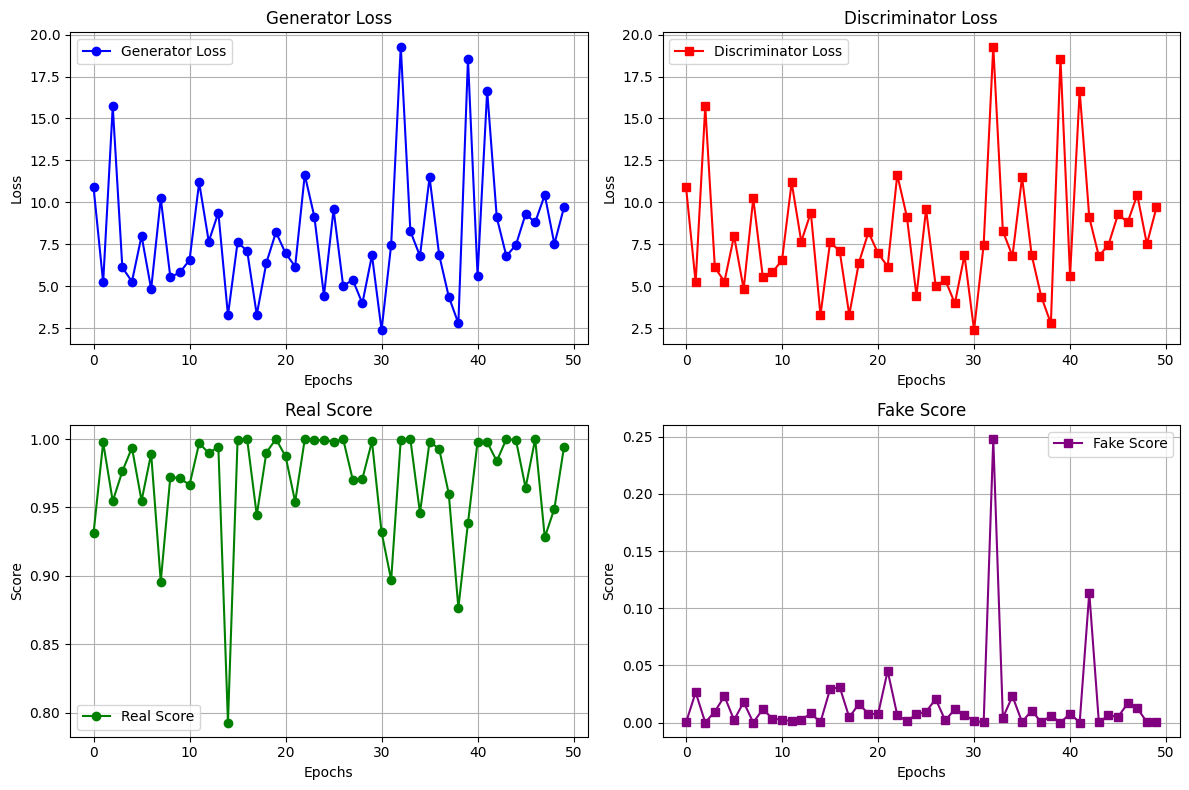

In [28]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
def plot_loss_curve_grid(results: dict[str, list[float]]) -> None:
    """
    Plots training curves of a results dictionary.
    Args:
        results (dict): Dictionary containing lists of values.
            Example:
            {'loss_generator': [float],
             'loss_discriminator': [float],
             'real_scores': [float],
             'fake_scores': [float]}
    Plots:
        - Generator Loss over epochs.
        - Discriminator Loss over epochs.
        - Real Score over epochs.
        - Fake Score over epochs.
    """

    loss_generator = results['loss_generator']
    loss_discriminator = results['loss_discriminator']
    real_scores = results['real_scores']
    fake_scores = results['fake_scores']

    epochs = range(len(loss_generator))

    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(epochs, loss_generator, marker='o', color='b', label='Generator Loss')
    ax1.set_title('Generator Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(epochs, loss_discriminator, marker='s', color='r', label='Discriminator Loss')
    ax2.set_title('Discriminator Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(epochs, real_scores, marker='o', color='g', label='Real Score')
    ax3.set_title('Real Score')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Score')
    ax3.legend()
    ax3.grid(True)

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(epochs, fake_scores, marker='s', color='purple', label='Fake Score')
    ax4.set_title('Fake Score')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Score')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.show()
plot_loss_curve_grid(results)

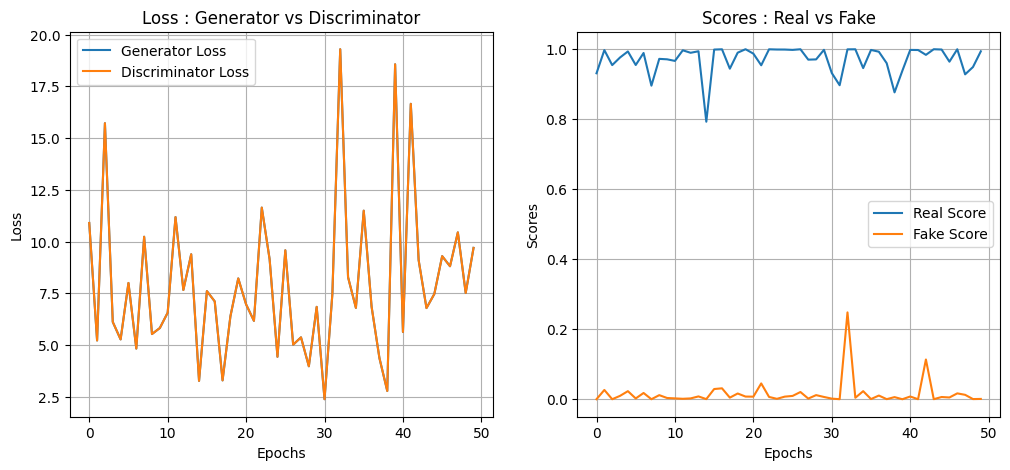

In [29]:
def plot_loss_curves(results: dict[str, list[float]]) -> None:
    """
    Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {'loss_generator' : [],
            'loss_discriminator' : [],
            'real_scores' : [],
            'fake_scores' : [],}
    """
    loss_generator = results['loss_generator']
    loss_discriminator = results['loss_discriminator']

    real_scores = results['real_scores']
    fake_scores = results['fake_scores']

    epochs = range(len(results['loss_generator']))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_generator, label='Generator Loss')
    plt.plot(epochs, loss_discriminator, label='Discriminator Loss')
    plt.title('Loss : Generator vs Discriminator')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, real_scores, label='Real Score')
    plt.plot(epochs, fake_scores, label='Fake Score')
    plt.title('Scores : Real vs Fake')
    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.legend()
    plt.grid(True)
plot_loss_curves(results)

In [30]:
sample_dir = 'Generated Images'
os.makedirs(sample_dir, exist_ok=True)

In [33]:
from IPython.display import Image
Image('/kaggle/working/Generated Images/generated-images-0007.png')

In [35]:
Image('/kaggle/working/Generated Images/generated-images-0017.png')

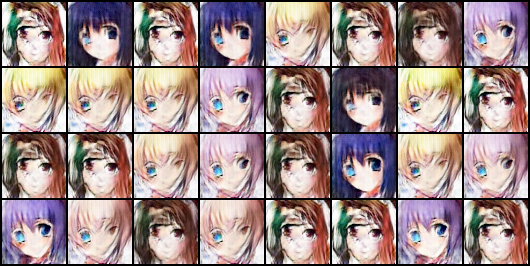

In [36]:
Image('/kaggle/working/Generated Images/generated-images-0027.png')

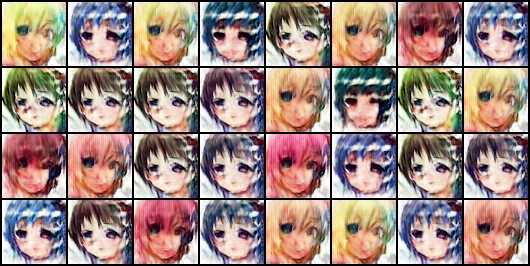

In [37]:
Image('/kaggle/working/Generated Images/generated-images-0037.png')

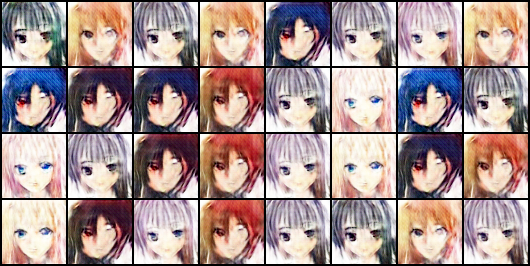

In [41]:
Image('/kaggle/working/Generated Images/generated-images-0048.png')

## 10. Save and load best performing model

Let's finish this section off by saving and loading in our best performing model.

* `torch.save` - a function to save a whole PyTorch model or a model's `state_dict()`.
* `torch.load` - a function to load in a saved PyTorch object.
* `torch.nn.Module.load_state_dict()` - a function to load a saved `state_dict()` into an existing model instance.

You can see more of these three in the [PyTorch saving and loading models documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

For now, let's save our `generator`'s `state_dict()` then load it back in and evaluate it to make sure the save and load went correctly.

In [43]:
from pathlib import Path

MODEL_PATH = Path("pytorch saved models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "AnimeFaceGANs.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=generator.state_dict(),f=MODEL_SAVE_PATH)

Saving model to: pytorch saved models/AnimeFaceGANs.pth


In [45]:
loaded_model = generator
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model = loaded_model.to(device)

Saving generated-images-0051.png


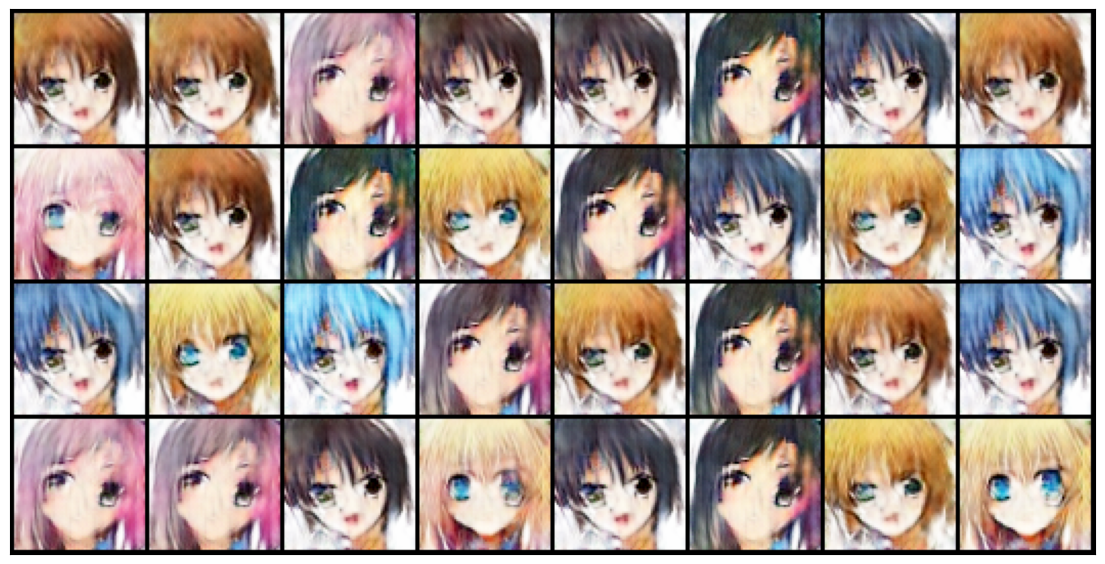

In [58]:
fixed_latent = torch.randn([BATCH_SIZE , NOISE_DIM , 1, 1] ,device = device)
save_image_grid(51, loaded_model,fixed_latent )